In [ ]:
# Math tools
import numpy as np

# Visualization tools
import plotly.graph_objs as go
import matplotlib.pyplot as plt

### Algorithm 1
**Input**: $ x^0 \in \mathbb{R}^n $, $ \gamma(\cdot) $, $ w(\cdot) $ definidos previamente, tamaño de lote constante $ \nu $, número de iteraciones $ k^{\text{max}} $.

**Initialization**: Sea $ \sigma := 0 $ (suma de los pesos) y $ \bar{x}^0 := 0 $ (suma pesada de las iteraciones).

**For** $ k = 0, 1, \ldots, k^{\text{max}} - 1 $ **do**

1. Seleccionamos un lote $ S_k $ de tamaño $ |S_k| = \nu $ i.i.d. de $\{1, \ldots, m\}$.

2. Sea $ x^{k+1} := x^k - \gamma(k) \nabla f_{S_k}(x^k) $.

3. Sea $ \bar{x}^{k+1} := \bar{x}^k + w(k+1)x^{k+1} $ y $ \sigma := \sigma + w(k+1) $.

El promedio pesado $ \bar{x}^{\text{final}} := \bar{x}^{k^{\text{max}}} / \sigma $ y devuelve $ \bar{x}^{\text{final}} $ como aproximación del minimizador de $ f $.


### Implementación

In [ ]:
class SGDWeighted:
    """
    Stochastic Gradient Descent by weighted averaging
        constanst from paper:
        alpha  := step_alpha
        c      := step_c
        M      := step_M
        beta   := weight_beta
        k_max  := num_iterations
        gamma  := step_scheduler
        omega  := weight_scheduler
    """

    def __init__(self, params, grad, step_alpha, step_c, step_M, weight_beta, num_iterations, num_fncs, batch_size):
        self.iterate          = params.copy()
        self.grad             = grad
        self.num_iterations   = num_iterations
        self.batch_size       = batch_size
        self.time_steps       = np.arange(0, num_iterations + 1)
        self.step_scheduler   = step_c * np.power(step_M / (self.time_steps + step_M), step_alpha)
        self.weight_scheduler = np.power(self.time_steps, weight_beta)
        self.num_fncs         = np.arange(num_fncs)
        self.history          = {'iterates': [], 'weighted_iterates': [], 'grad': [], 'grad_weight': []}

        assert batch_size < num_fncs

    def optimize(self):
        """ Optimization algorithm """

        sum_weights = 0
        cum_wighted_sum_iterates = 0

        for k in range(self.num_iterations):

            batch_idx = np.random.choice(self.num_fncs, self.batch_size, replace=False)
            grad = self.grad(self.iterate, batch_idx)
            self.iterate -= self.step_scheduler[k] * grad

            cum_wighted_sum_iterates += self.weight_scheduler[k+1] * self.iterate
            sum_weights += self.weight_scheduler[k+1]

            # keep track of iterations and grads
            self.history['iterates'].append(self.iterate)
            self.history['weighted_iterates'].append(cum_wighted_sum_iterates / sum_weights)
            self.history['grad'].append(grad)
            self.history['grad_weight'].append(self.grad(cum_wighted_sum_iterates / sum_weights, batch_idx))


        return cum_wighted_sum_iterates / sum_weights


Usaremos como baseline, el algortitmo de descenso de gradiente con backtracking.

In [ ]:
def backtracking_armijo(alpha_init, rho, c1, x_k, fnc, grad, p_k,  maxIter):
    alpha = alpha_init
    for i in range(maxIter):
        # armijo
        if fnc(x_k + alpha * p_k) <= fnc(x_k) + c1 * alpha * (grad(x_k).T @ p_k):
            return alpha, i+1
        alpha *= rho
    return alpha, maxIter

class GradDBT:
    def __init__(self, fnc, grad, x_init, tol, maxIter):
        self.fnc = fnc
        self.grad = grad
        self.x = x_init.copy()
        self.tol = tol
        self.maxIter = maxIter
        self.bres = False

    def solve(self, rho, c1, maxIter_bt):
        for k in range(self.maxIter):
            p = -self.grad(self.x)
            if np.linalg.norm(p) < self.tol:
                self.bres = True
                return self.x, -p, k + 1, self.bres
            alpha, _ = backtracking_armijo(1, rho, c1, self.x, self.fnc, self.grad, p, maxIter_bt)
            self.x += alpha * p
        return self.x, -p, self.maxIter, self.bres

## Experimentación

### Para desarrollar los experimentos implementamos una clase para calcular el promedio de las funciones cuadráticas, de tal forma que este optimizada para trabajar con lotes.

In [ ]:
class StrongConvexQuadraticFnc:
    """
    Strongly convex quadratic function

        items = {
            matrix   : [list of matrices A],
            vector   : [list of vectors b],
            constant : [list of constant vectors c]
        }
    """

    def __init__(self, items):
        self.items = items
        self.num_fncs = len(items['matrix'])

    def mono(self, x, idx):
        A = self.items['matrix'][idx]
        b = self.items['vector'][idx]
        c = self.items['constant'][idx]
        return 0.5 * np.einsum('...i,ij,...j->...', x, A, x) + np.einsum('...i,i->...', x, b) + c

    def mono_grad(self, x, idx):
        A = self.items['matrix'][idx]
        b = self.items['vector'][idx]
        return np.einsum('ij,...j->...i', A, x) + b

    def fnc(self, X, batch_idx):
        A_stack = np.array(self.items['matrix'])[batch_idx]
        b_stack = np.array(self.items['vector'])[batch_idx]
        c_stack = np.array(self.items['constant'])[batch_idx]

        # Ensure X is 2-dimensional
        if X.ndim == 1:
            X = X[np.newaxis, :]

        X_expanded = X[:, np.newaxis, :]  # Expand dimensions for batch processing

        part1 = 0.5 * np.einsum('...i,...ij,...j->...', X_expanded, A_stack, X_expanded)
        part2 = np.einsum('...i,...i->...', X_expanded, b_stack)

        result = (part1 + part2 + c_stack).mean(axis=-1)

        return result

    def grad(self, X, batch_idx):
        A_stack = np.array(self.items['matrix'])[batch_idx]
        b_stack = np.array(self.items['vector'])[batch_idx]

        # Ensure X is 2-dimensional
        if X.ndim == 1:
            X = X[np.newaxis, :]

        grad_result = np.einsum('...ij,...j->...i', A_stack, X[:, np.newaxis, :]) + b_stack

        return grad_result.squeeze().mean(0)

### Matrices Diagonales


Podemos notar que para una función que cumple todos los supuestos del paper logra minimizar adecuadamente con un batch de tan solo $8$ o $16$ incluso cuando la funcion requiere de $1000$ sumas

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Create the items dictionary
N = 1000
dim = 2
items = {"matrix": [], "vector": [], "constant": []}
for i in range(N):
    items["matrix"].append(np.diag(np.random.rand(dim)))
    items["vector"].append(np.zeros(dim))
    items["constant"].append(0)

# Instantiate the function class
strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
batch = np.arange(N)

In [ ]:
# Set Up
k_max      = 5000
alpha      = 0
beta       = 0.7116
c          = 1
M          = 1
batch_size = 8
grad       = strong_con_quad_fnc.grad

strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
x0 = np.array([50, 50], dtype=float)
sgd_weighted = SGDWeighted(x0,
                           grad,
                           step_alpha=alpha,
                           step_c=c,
                           step_M=M,
                           weight_beta=beta,
                           num_iterations=k_max,
                           num_fncs=N,
                           batch_size=batch_size)

minimizer = sgd_weighted.optimize()
z = strong_con_quad_fnc.fnc(minimizer, batch)
print(f"Minimizador: {minimizer}")
print(f"Evaluación:  {z}")

Minimizador: [6.90186462e-05 3.78845908e-05]
Evaluación:  [1.52933746e-09]


In [ ]:
# Set Up
k_max      = 5000
alpha      = 0
beta       = 0.7116
c          = 1
M          = 1
batch_size = 16
grad       = strong_con_quad_fnc.grad

strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
x0 = np.array([50, 50], dtype=float)
sgd_weighted = SGDWeighted(x0,
                           grad,
                           step_alpha=alpha,
                           step_c=c,
                           step_M=1,
                           weight_beta=0,
                           num_iterations=k_max,
                           num_fncs=N,
                           batch_size=batch_size)

minimizer = sgd_weighted.optimize()
z = strong_con_quad_fnc.fnc(minimizer, batch)
print(f"Minimizador: {minimizer}")
print(f"Evaluación:  {z}")

Minimizador: [0.00957001 0.0103252 ]
Evaluación:  [4.94864803e-05]


In [ ]:
# ---> GD Backtracking

strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
batch = np.arange(N)

grad_bt = GradDBT(lambda x: strong_con_quad_fnc.fnc(x, batch),
                  lambda x: strong_con_quad_fnc.grad(x, batch),
                  x0,
                  np.sqrt(np.finfo(float).eps),
                  k_max)
x, g, iters, _ = grad_bt.solve(0.5, 0.001, 500)

z = strong_con_quad_fnc.fnc(minimizer, batch)
print(f"Minimizador: {x}")
print(f"Evaluación:  {z}")

Minimizador: [2.34500362e-08 6.79741468e-09]
Evaluación:  [4.94864803e-05]




---



Veamos que si lo probamos en un contexto más amplio, el algoritmo no alcanza un rendimiento deseable.

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Create the items dictionary
N = 1000
dim = 2
items = {"matrix": [], "vector": [], "constant": []}
for i in range(N):
    items["matrix"].append(np.diag(np.random.rand(dim)))
    items["vector"].append(np.random.rand(dim))
    items["constant"].append(np.random.rand())

# Instantiate the function class
strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
batch = np.arange(N)

# Set Up
k_max      = 5000
alpha      = 0
beta       = 0.7116
c          = 1
M          = 1
batch_size = 8
grad       = strong_con_quad_fnc.grad

strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
x0 = np.array([50, 50], dtype=float)
sgd_weighted = SGDWeighted(x0,
                           grad,
                           step_alpha=alpha,
                           step_c=c,
                           step_M=M,
                           weight_beta=beta,
                           num_iterations=k_max,
                           num_fncs=N,
                           batch_size=batch_size)

minimizer = sgd_weighted.optimize()
z = strong_con_quad_fnc.fnc(minimizer, batch)
print(f"Minimizador: {minimizer}")
print(f"Evaluación:  {z}")

Minimizador: [-0.98273228 -1.00021595]
Evaluación:  [0.01057479]


In [ ]:
# ---> GD Backtracking

strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
batch = np.arange(N)

grad_bt = GradDBT(lambda x: strong_con_quad_fnc.fnc(x, batch),
                  lambda x: strong_con_quad_fnc.grad(x, batch),
                  x0,
                  np.sqrt(np.finfo(float).eps),
                  k_max)
minimizer_bt, g, iters, _ = grad_bt.solve(0.5, 0.001, 500)

z_bt = strong_con_quad_fnc.fnc(minimizer_bt, batch)
print(f"Minimizador: {minimizer_bt}")
print(f"Evaluación:  {z_bt}")

Minimizador: [-0.98687618 -0.99543377]
Evaluación:  [0.01056481]


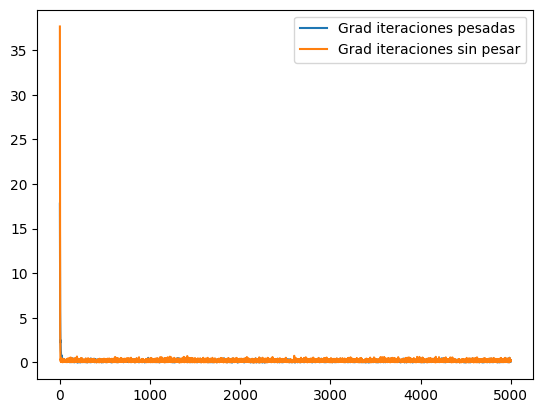

In [ ]:
history = sgd_weighted.history
x   = np.arange(k_max)
y_w = np.linalg.norm(history['grad_weight'], axis=-1).reshape(-1)
y   = np.linalg.norm(history['grad'], axis=-1).reshape(-1)

plt.plot(x, y_w, label='Grad iteraciones pesadas')
plt.plot(x, y, label='Grad iteraciones sin pesar')
plt.legend()
plt.show()

In [ ]:
# Define the range for theta_1 and theta_2
theta_1 = np.linspace(-100, 100, 100)
theta_2 = np.linspace(-100, 100, 100)
X, Y = np.meshgrid(theta_1, theta_2)

# Flatten the meshgrid to iterate over each element
X_flat = np.vstack([X.ravel(), Y.ravel()]).T

# Compute the function value for each (x, y) pair
Z_flat = strong_con_quad_fnc.fnc(X_flat, batch)

# Reshape the result back to the original grid shape
Z = Z_flat.reshape(X.shape)

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# Add the point using Scatter3d
point_trace = go.Scatter3d(x=[minimizer[0]], y=[minimizer[1]], z=z,
                           mode='markers',
                           marker=dict(size=5, color='red'),
                           text=['Aproximación del mínimo'],  # Name of the point
                           textposition='top center',  # Position of the text
                           hoverinfo='text+x+y+z')  # Information to display on hover
fig.add_trace(point_trace)

# Add the point using Scatter3d
point_trace = go.Scatter3d(x=[minimizer_bt[0]], y=[minimizer_bt[1]], z=z_bt,
                           mode='markers',
                           marker=dict(size=5, color='green'),
                           text=['Aproximación del mínimo con bt'],  # Name of the point
                           textposition='top center',  # Position of the text
                           hoverinfo='text+x+y+z')  # Information to display on hover


fig.add_trace(point_trace)

# Customize the layout
fig.update_layout(title='3D Surface Plot of the Quadratic Function',
                  scene=dict(
                      xaxis_title='Theta 1',
                      yaxis_title='Theta 2',
                      zaxis_title='Function Value'))

# Show the plot
fig.show()


### Matrices no-diagonales

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Create the items dictionary
N = 1000
dim = 2
items = {"matrix": [], "vector": [], "constant": []}
for i in range(N):
    items["matrix"].append(np.random.rand(dim, dim))
    items["vector"].append(np.random.rand(dim))
    items["constant"].append(np.random.rand())

# Instantiate the function class
strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
batch = np.arange(N)

# Set Up
k_max      = 5000
alpha      = 0
beta       = 0.7116
c          = 1
M          = 1
batch_size = 8
grad       = strong_con_quad_fnc.grad

strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
x0 = np.array([20, 20], dtype=float)
sgd_weighted = SGDWeighted(x0,
                           grad,
                           step_alpha=alpha,
                           step_c=c,
                           step_M=M,
                           weight_beta=beta,
                           num_iterations=k_max,
                           num_fncs=N,
                           batch_size=batch_size)

minimizer = sgd_weighted.optimize()
z = strong_con_quad_fnc.fnc(minimizer, batch)
print(f"Minimizador: {minimizer}")
print(f"Evaluación:  {z}")

Minimizador: [-331.94267404  331.04178637]
Evaluación:  [-480.33960108]


In [ ]:
# ---> GD Backtracking

# strong_con_quad_fnc = StrongConvexQuadraticFnc(items)
# batch = np.arange(N)

grad_bt = GradDBT(lambda x: strong_con_quad_fnc.fnc(x, batch),
                  lambda x: strong_con_quad_fnc.grad(x, batch),
                  x0,
                  np.sqrt(np.finfo(float).eps),
                  k_max)
minimizer_bt, g, iters, _ = grad_bt.solve(0.5, 0.001, 500)

z_bt = strong_con_quad_fnc.fnc(minimizer_bt, batch)
print(f"Minimizador: {minimizer_bt}")
print(f"Evaluación:  {z_bt}")
print(f"Iteraciones:  {iters}")

Minimizador: [-3.57528554e+09  3.59190276e+09]
Evaluación:  [-5.59902715e+16]
Iteraciones:  5000


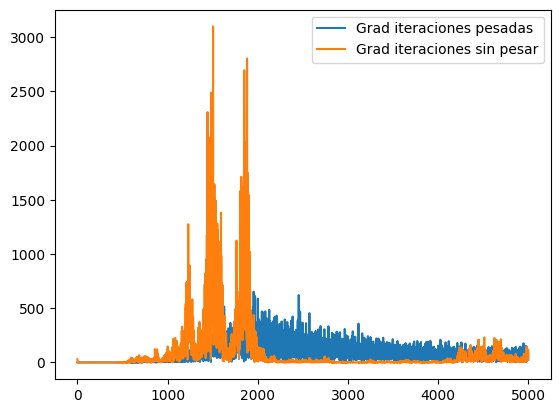

In [ ]:
history = sgd_weighted.history
x   = np.arange(k_max)
y_w = np.linalg.norm(history['grad_weight'], axis=-1).reshape(-1)
y   = np.linalg.norm(history['grad'], axis=-1).reshape(-1)

plt.plot(x, y_w, label='Grad iteraciones pesadas')
plt.plot(x, y, label='Grad iteraciones sin pesar')
plt.legend()
plt.show()

In [ ]:
# Define the range for theta_1 and theta_2
theta_1 = np.linspace(-400, 400, 100)
theta_2 = np.linspace(-400, 400, 100)
X, Y = np.meshgrid(theta_1, theta_2)

# Flatten the meshgrid to iterate over each element
X_flat = np.vstack([X.ravel(), Y.ravel()]).T

# Compute the function value for each (x, y) pair
Z_flat = strong_con_quad_fnc.fnc(X_flat, batch)

# Reshape the result back to the original grid shape
Z = Z_flat.reshape(X.shape)

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# Add the point using Scatter3d
point_trace = go.Scatter3d(x=[minimizer[0]], y=[minimizer[1]], z=z,
                           mode='markers',
                           marker=dict(size=5, color='red'),
                            text=['Aproximación del mínimo'],  # Name of the point
                           textposition='top center',  # Position of the text
                           hoverinfo='text+x+y+z')  # Information to display on hover


fig.add_trace(point_trace)

# Customize the layout
fig.update_layout(title='3D Surface Plot of the Quadratic Function',
                  scene=dict(
                      xaxis_title='Theta 1',
                      yaxis_title='Theta 2',
                      zaxis_title='Function Value'))

# Show the plot
fig.show()


## Conclusión

En este trabajo presentamos una versión de SGD que optimiza la convergencia utilizando el promedio ponderado de iteraciones. La elección de los parámetros desempeña un papel crucial en el equilibrio entre la reducción del error estocástico y la garantía de convergencia, lo que conduce a un algoritmo de optimización más eficiente. Los experimentos demuestran la eficacia del algoritmo bajo los supuestos teóricos del artículo.
